<a href="https://colab.research.google.com/github/rigonzal/ML-2019-1/blob/master/Tarea1/Pregunta2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-393: Máquinas de Aprendizaje
## Tarea 1 - Pregunta 2
### 26-04-2019


* Rodrigo González - 201303026-2
* Ignacio Valenzuela - 201473055-1


# 2. Selección de Atributos

En esta sección se hará un análisis de un dataset que almacena datos sobre ventas de vivienda, especificando sus costos y ciertas características de cada vivienda. El fin de este análisis será descubrir patrones no tan evidentes que puede tener implicancia en la preferencia de los compradores. Lo anterior puede ayudar bastante a los vendedores para lograr establecer un precio adecuado a sus viviendas o también llamar mejor la atención de los compradores.

## 2.1) Carga de datos

Realizaremos la carga del dataset junto a la importación de módulos esenciales para el análisis

In [0]:
!pip install -U -q PyDrive

    100% |████████████████████████████████| 993kB 20.6MB/s 


In [0]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from google.colab import drive
from operator import itemgetter
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv("/content/drive/My Drive/Pregunta 1/kc_house_data.csv")

In [0]:
df[:5]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Podemos apreciar que el dataset se cargó correctamente. Una columna bastante interesante es la de date, la cual vemos que esta en un formato extraño. Aun así, podemos apreciar que posee un formato de YY-MM-DD seguido de una T y 0's. Con la siguiente función podemos corregir esto.

In [0]:
def to_num(date):
    nums = list(date)
    res = 0
    for i in range(8):
        res = res + int(nums[i])*(10**(7-i))
    return res

Sabemos que la fecha posee al comienzo 8 carácteres que nos interesan, mientras que desde el T hacia adelante no dan información relevante. Esta función tomará una fecha y analizará los primeros 8 carácteres. A cada número se le multiplacará con una potencia de 10 que represente su posición (centena, decena, unidad, etc) el cual será devuelto en formato de un entero como corresponda. Gracias a las cualidades del DataFrame de Pandas, podemos aplicar esta simple función a cada entrada del dataset con una simple línea de código.

In [0]:
df['date'] = df.date.apply(to_num).rank()

In [0]:
df[:5]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10544.0,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,13682.5,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,16699.0,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,13682.5,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,16276.0,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Ahora obtenemos un valor que representa un ranking para las fechas. En estos momentos no nos interesa bastante la fecha en la que se produjo cada venta, por lo que se transforma en un ranking, siendo 1 la venta más antigua y la siguiente queda en segundo lugar y así sucesivamente. Ahora analizaremos cada columna para ver cuales son las que realmente nos ayudarán en el análisis. Desde la misma página de kaggle obtenemos exactamente a qué se refiere cada columna.


1.   Bedrooms: La cantidad de piezas que posee esa casa
2.   Bathrooms: La cantidad de baños que posee la casa. En esta columna hay que detenerse un poco. Analizando sus valores podemos notar lo siguiente:



In [0]:
print(df.bathrooms.unique(), len(df.bathrooms.unique()))

[1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 0.   1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75
 6.25 6.5 ] 30


Tenemos valores decimales, lo que no hace mucho sentido siendo que estamos contando la cantidad de baños. La explicación es debido a la notación que usan los americanos para definir el número de baños. Existen tres tipos de baños, los baños completos que poseen ducha, bañera, lavamanos y retrete. Los '3/4' de baños que poseen lavamanos, retrete y ducha. Por último, existen los medios baños que solo tienen retrete y lavamanos. Con esta clasificación, un baño completo sería 1, un '3/4' sería 0.75 y un medio baño un 0.5. Por lo tanto, si una casa tiene un valor de 2.25 de baños, implica que posee un baño completo, uno medio y uno '3/4' (1 + 0.75 + 0.5 = 2.25). Aún así la notación es bastante compleja ya que si una casa tiene un valor de 6.5 de baños, no se sabe si son 6 baños completos y uno medio u otra combinación de baños que su suma de igualmente 6.5. La elección de un baño generalmente es importante en la compra de una casa por lo que esta columna se considerará a pesar de la ambiguedad del valor.


3.   sqft_living: Es la medición de pies cuadrados de la casa. Claramente es un dato importante al definir el precio.
4.   sqft_lot: Medición en pies cuadrdos de la parcela completa. Mientras mas 'patio' posea una casa implica un valor más alto, ya que el terreno completo es mayor.
5.   Floor: Este atributo indica la cantidad de pisos. También tiene un valor decimal en la cual no hay información que explique. A primera instancia podría referirse a la presencia de un sótano, pero no concuerda con los valores de la columna sqft_basement, donde en muestras donde existe un sótano, los pisos no presentan un valor decimal. Podría suponerse también a una alcoba, pero los americanos generalmente denominan a eso también como un sótano.


In [0]:
print(df.floors.unique())

[1.  2.  1.5 3.  2.5 3.5]




6.   Waterfront: Indica si la casa posee vista al mar.
7.   View: Según la descripción, es si la casa a sido vista por otro comprador o no. Como no es una variable binaria y va desde 0 a 4, se supondrá que indica la cantidad de veces que han visto esa vivienda.
8.   Overall: La condición en la que se encuentra la vivienda  (en promedio)
9.   Grade: grado total que recibe la vivienda, basado en el sistema que posee King County
10. sqft_above: Es la cantidad en pies cuadrados de la vivienda sin considerar el sótano
11. sqft_basement: Es el tamaño en pies cuadrados solamente del sótano, en caso de tener.
12. yr_built: Año en el que se construyó la casa
13. yr_renovated: Año en la cual fue la última renovación de la casa
14. zipcode: El código de envío de la vivienda
15. lat y long: Corresponde a las coordenadas de latitud y longitud de la vivienda. En general, estos datos sirven solo para obtener la ubicación exacta de la vivienda y saber donde se encuentra, pero es un valor que no presenta una gran importancia a la hora de vender una vivienda. Si quisiésemos saber realmente como afectaría en que lugar esta la vivienda necesitariamos más información del estado, vecindad, etc. Por el momento, estas columnas serán retiradas del análisis ya que con el zipcode ya podemos tener una mejor idea de la ubicación de la vivienda.
16. sqft_living15 y sqft_lot15: Dos columnas que representan la misma información que sqft_living y sqft_lot, respectivamente, pero en el año 2015. Esto dará a entender que probablemente después de 2015 se realizó una renovación que pudo implicar extensiones, las cuales se ven reflejadas en las primeras dos columnas. Esta variable es importante ya que explicará el aumento del costo de la vivienda y otras variables mas.


In [0]:
df = df.drop(columns = ['id', 'lat', 'long'])

Por último, revisaremos si el dataset posee algún valor nulo o NaN

In [0]:
df.isnull().values.any()

False

Por lo que todos los datos del dataset son válidos para trabajar. Por último hay un outlier bien peculiar que analizar respecto a la cantidad de piezas.

In [0]:
df.loc[df.bedrooms == 33]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
15870,3563.0,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,1330,4700


Poseemos una casa que posee 33 piezas y otros datos que no hacen sentido. ¿Como podrá tener 33 piezas en un tamaño de 1620 pies cuadrados y con un solo piso? El promedio una pieza americana es generalmente de 100 pies cuadrados, por lo que habría como máximo 16 piezas, sin considerar baños, cocinas, etc. Además, considerando las casas con las mismas características tenemos lo siguiente:

In [0]:
df.loc[(df.sqft_living < 1800) & (df.sqft_living > 1400)].bedrooms.mean()

3.1247992658866712

Generalmente las casas que poseen en un rango cercano de 1620 tienen un promedio de 3 habitaciones. Por lo tanto, podemos concluir que fue un error de tipeo, donde se quizo colocar una cantidad de 3 habitaciones pero se repitió ese valor. Como nuestra intención posteriormente es estandarizar los datos, ese outlier nos aumentará un poco la desviación estándar del atributo, por lo que lo sacaremos del dataset.

In [0]:
df = df.drop(15870)

## 2.2) Preprocesamiento de datos y visualización.

Primero que todo analizaremos los atributos con un gráfico scatter, analizando la relación que existen entre ellos.

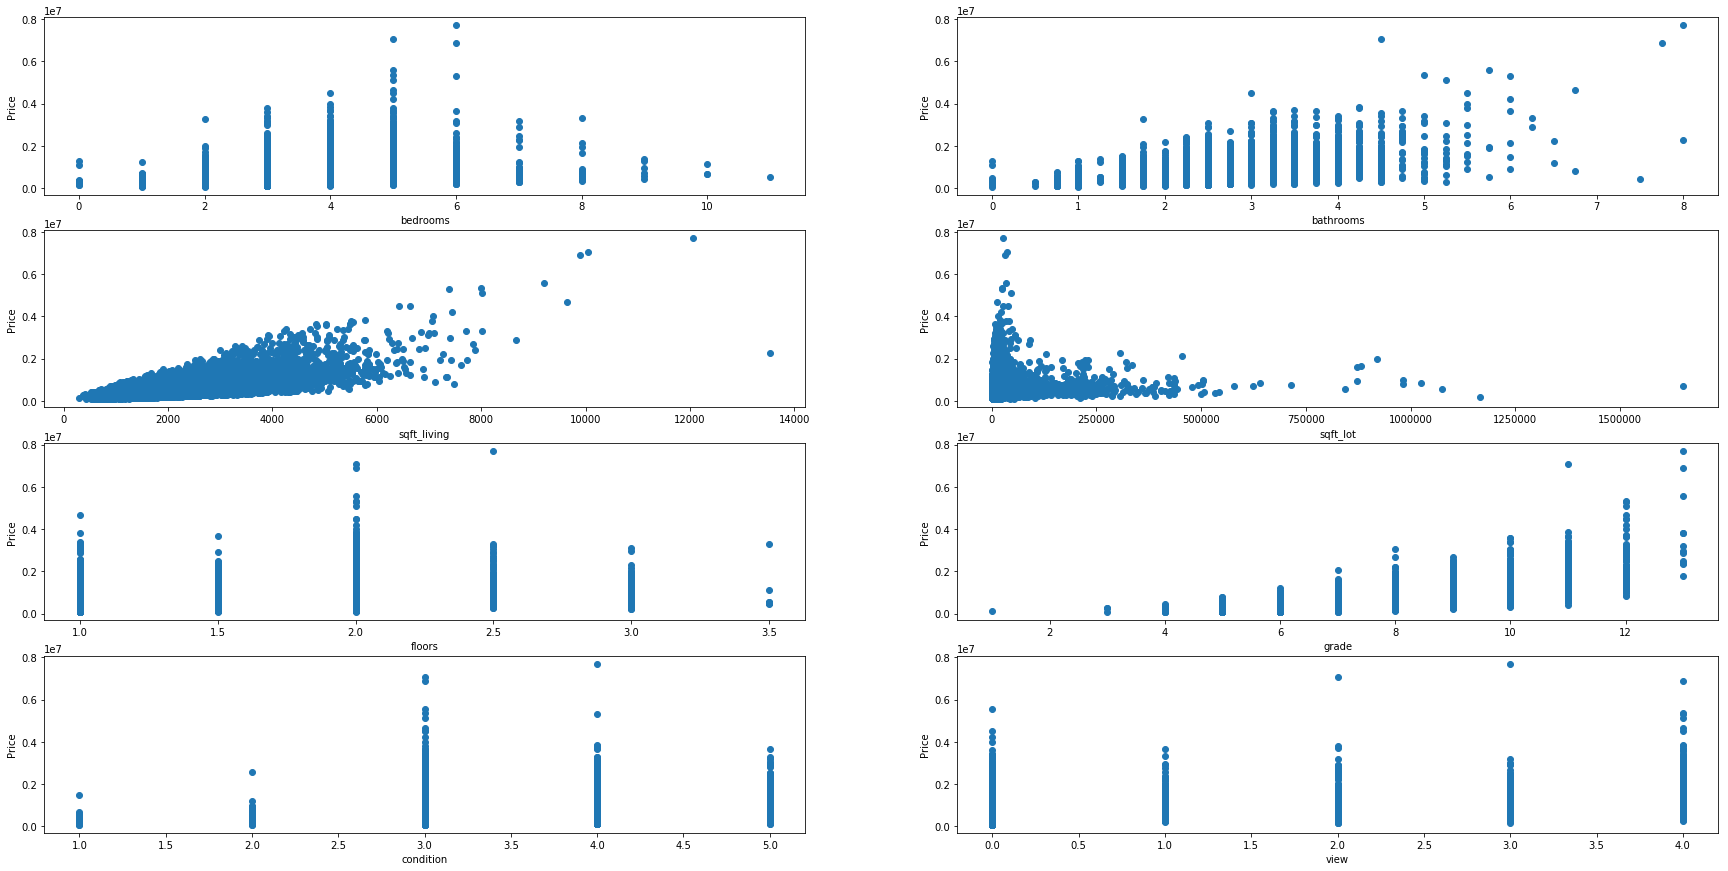

In [0]:
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'condition', 'view']
plt.figure(figsize=(30,15))
for i in range(1,9):
  plt.subplot(4, 2, i)
  plt.xlabel(columns[i-1])
  plt.ylabel('Price')
  plt.scatter(df[columns[i-1]], df.price)

Se puede apreciar que hay una relación en el precio con las variables sqft_living, grade y bathrooms. Mientras más aumentan estas variables el precio tiende a hacer lo mismo, viéndose más notorio con el atributo de sqft_living, lo cual tiene sentido ya que claramente una casa más grande implica un costo mayor.  Respecto a los pisos no se encuentra un patrón lo suficientemente notable. El de dos pisos se ve el más destacable pero es claramente por una mayor cantidad de muestras con esa características, ampliando la diversidad de los precios. Otro factor son los dormitorios, donde vemos que el precio aumenta en los valores centrales y disminuye en los extremos. Se puede explicar también que pocos dormitorios no implican tanto gasto, y una gran cantidad de dormitorios podría implicar que sean tan pequeños (para que alcanzen en la vivienda) que la gente prefiere menos pero con más espacios. El que hace un poco mas de ruido es la del atributo de sqft_lot, donde vemos que aunque aumente el tamaño del terreno no implica un aumento del precio, es más, las viviendas que son más pequeñas parecen tener un aumento de precio. 

Haremos los mismos gráficos pero usando otras transformaciones en los datos para captar la presencia de algunos patrones interesantes.

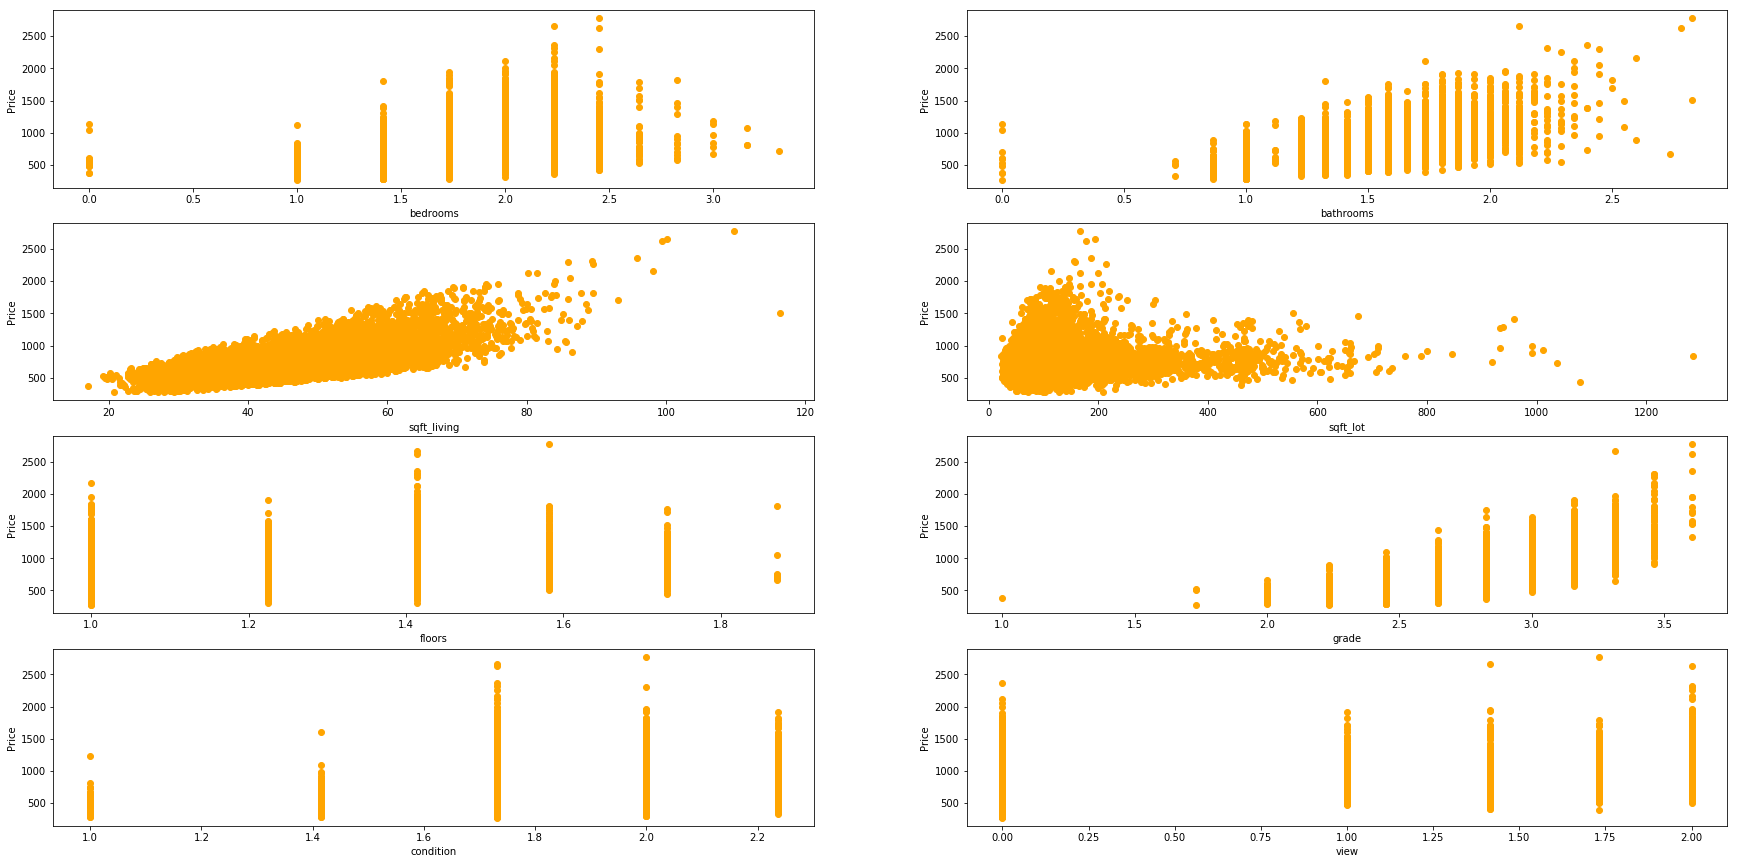

In [0]:
plt.figure(figsize=(30,15))
for i in range(1,9):
  plt.subplot(4, 2, i)
  plt.xlabel(columns[i-1])
  plt.ylabel('Price')
  plt.scatter(df[columns[i-1]].apply(np.sqrt), df.price.apply(np.sqrt), color = 'orange')

En los scatters anteriores vemos que los sqft_living y sqft_lot muestran un poco más de concentración y que los datos no están tan concentrados en un solo punto. Por parte de los demás atributos, solo el de los baños tienda a concentrar los datos mas al centro que de los normales. Ahora, aplicando una función logarítmica.

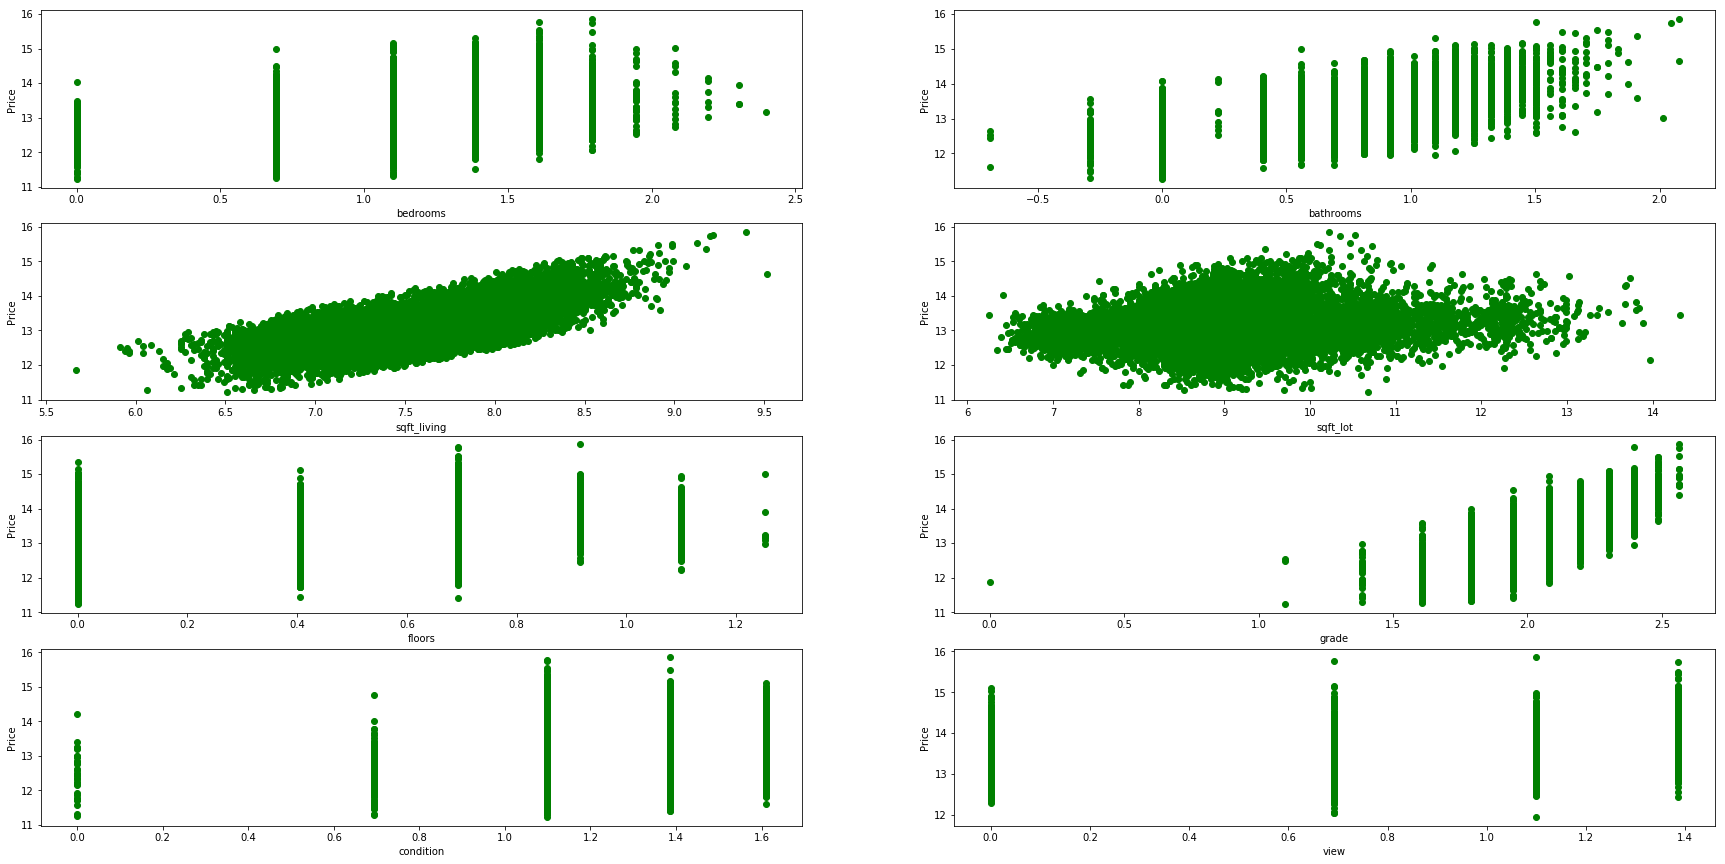

In [0]:
plt.figure(figsize=(30,15))
for i in range(1,9):
  plt.subplot(4, 2, i)
  plt.xlabel(columns[i-1])
  plt.ylabel('Price')
  plt.scatter(df[columns[i-1]].apply(np.log), df.price.apply(np.log), color = 'green')

En esta ocasión podemos apreciar mejor las cosas. En las dos variables sqft vemos que se esparcen mas los datos mostrando notoriamente que mientras mas grande la casa tiende a costar más. También se presenta una mayor concentración en viviendas con terreno ni tan grande ni tan pequeño. El atributo 'grade' ahora si muestra una tendencia a que mientras más sea, mas cara es la vivienda, lo que hace más sentido ya que es una métrica que define que tan buena es la casa según el criterio de la misma ciudad.

## 2.3) Selección de Atributos by hand

Nuestra intención ahora es claramente entrenar el modelo. Debido a la cantidad de atributos y la estructura de los scatter observados nos dan indicios de ciertos comportamientos que podrían indicar si una casa vale más o no, es que se realizarán entrenamientos paulatinos, es decir, se entrenaran modelos considerando desde 1 atributo, aumentando paulatinamente hasta considerarlos todo. Con esto, lograremos detectar los atributos que mejor nos ayuden al modelo reduciendo el MSE. Finalmente, lograremos analizar los atributos que realmente aportan al modelo, y lograr descartar otros que no lo hagan para revisar si mejora aún mas el desempeño del modelo con estos 'supra' atributos por si solos.

Primero que todo, debemos separar la data en 75% entrenamiento, 15% validacion y 10% testing. Además se realizará la estandarización con StandardScaler.

In [0]:
data_pre_train, data_pre_test = train_test_split(df, test_size= 0.10)

data_y_train = data_pre_train.pop('price')
data_y_test = data_pre_test.pop('price')
data_x_train = data_pre_train
data_x_test = data_pre_test

data_y_train = data_y_train.values.reshape(-1,1)
data_y_test = data_y_test.values.reshape(-1,1)

standar_x = StandardScaler()
standar_x = standar_x.fit(data_x_train)

data_x_train = pd.DataFrame(standar_x.transform(data_x_train), columns=data_x_train.columns)
data_x_test = pd.DataFrame(standar_x.transform(data_x_test), columns=data_x_test.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [0]:
restantes = list(data_x_train.columns)
actuales = []
error_actual = ((data_y_train - data_y_train.mean())**2).mean()
all_errors = [error_actual]
print('0: None')
while restantes:
  errores = list()
  for atributo_candidato in restantes:
    model = LinearRegression()
    folds = KFold(5)
    featurerr = 0
    for train_index, test_index in folds.split(data_x_train.values):
      model.fit(data_x_train[actuales + [atributo_candidato]].values[train_index], data_y_train[train_index])
      predict = model.predict(data_x_train[actuales + [atributo_candidato]].values[train_index])
      featurerr += mean_squared_error(data_y_train[train_index], predict)
    errores.append(featurerr / 5)
  val, idx = min((val, idx) for (idx, val) in enumerate(errores))
  actuales.append(restantes[idx])
  del restantes[idx]
  all_errors.append(val)
  print(len(actuales), ": ", actuales)

0: None
1 :  ['sqft_living']
2 :  ['sqft_living', 'grade']
3 :  ['sqft_living', 'grade', 'yr_built']
4 :  ['sqft_living', 'grade', 'yr_built', 'waterfront']
5 :  ['sqft_living', 'grade', 'yr_built', 'waterfront', 'view']
6 :  ['sqft_living', 'grade', 'yr_built', 'waterfront', 'view', 'bedrooms']
7 :  ['sqft_living', 'grade', 'yr_built', 'waterfront', 'view', 'bedrooms', 'bathrooms']
8 :  ['sqft_living', 'grade', 'yr_built', 'waterfront', 'view', 'bedrooms', 'bathrooms', 'sqft_lot15']
9 :  ['sqft_living', 'grade', 'yr_built', 'waterfront', 'view', 'bedrooms', 'bathrooms', 'sqft_lot15', 'condition']
10 :  ['sqft_living', 'grade', 'yr_built', 'waterfront', 'view', 'bedrooms', 'bathrooms', 'sqft_lot15', 'condition', 'date']
11 :  ['sqft_living', 'grade', 'yr_built', 'waterfront', 'view', 'bedrooms', 'bathrooms', 'sqft_lot15', 'condition', 'date', 'sqft_living15']
12 :  ['sqft_living', 'grade', 'yr_built', 'waterfront', 'view', 'bedrooms', 'bathrooms', 'sqft_lot15', 'condition', 'date', 'sq

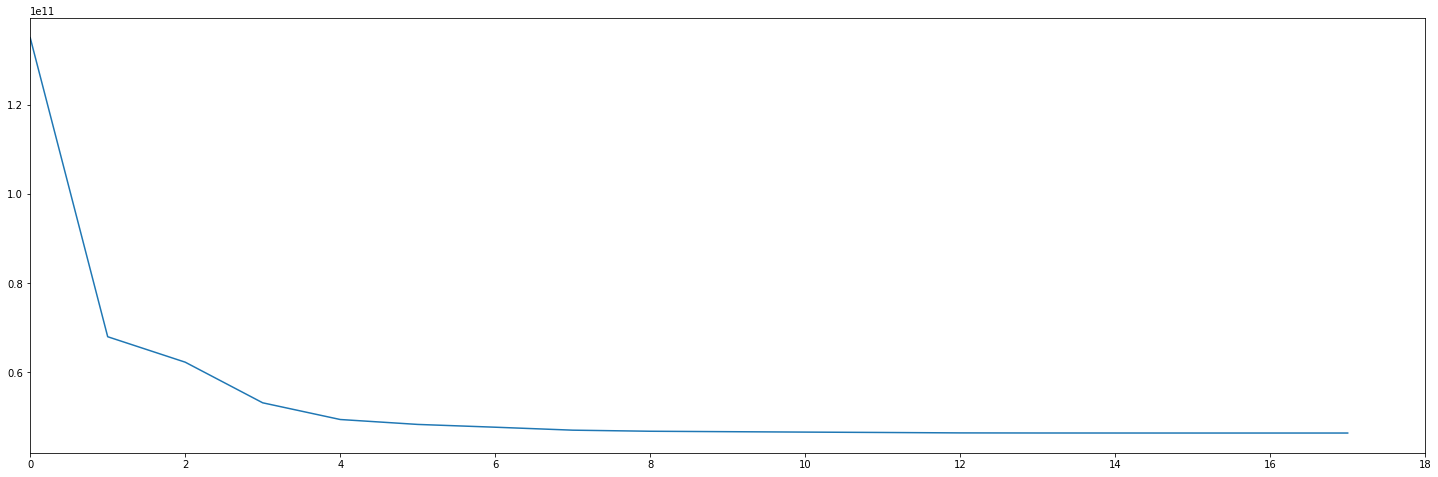

In [0]:
x = list(range(0,18))

plt.figure(figsize=(25,8))
plt.xlim(0,18)
plt.plot(x, all_errors)

A simple vista podemos apreciar que siempre el error va bajando, llegando a un punto donde las diferencias son mínimas. De momento tiene bastante sentido, principalmente porque siempre estamos escogiendo los atributos que nos reducen más el error, por lo que los atributos que se agregan después no aportarán tanta información como los primeros. En los print de la parte superior podemos ver los atributos que fueron incluidos para entrenar en cada iteración. Para analizar más minuciosamente, veremos si realmente siempre va bajando o hay diferencias mínimas donde un atributo puede aumentar el MSE (vemos que desde 8 atributos la línea parece ser casi constante, por lo que analizaremos desde allí en adelante)

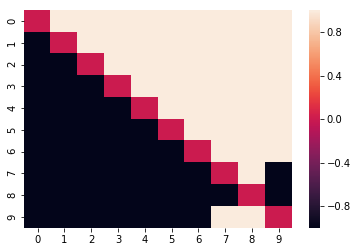

In [0]:
def heat(errors):
  matriz = np.zeros((len(errors), len(errors)))  
  for i in range(0, len(errors)):
    for j in range(0, len(errors)):
      if errors[i] < errors[j]:
        matriz[i][j] = -1
      elif errors[i] > errors[j]:
        matriz[i][j] = 1
  return sns.heatmap(matriz)

test_errors = all_errors[8:]
heat(test_errors)

In [0]:
print(all_errors)

[133908789225.70119, 67640140135.886795, 62056007952.364784, 57221676498.584946, 50328753197.78278, 48382594810.08614, 47770424141.69122, 47128472042.58471, 46912196924.80823, 46817570907.027084, 46728643446.531815, 46631606144.49831, 46540501246.7781, 46519923815.41128, 46516019788.01434, 46513099981.21568, 46504194122.36409, 46513101518.037796]


En este mapa de calor, podemos apreciar que siempre el error va disminuyendo excepto cuando se agrega el último atributo (zipcode) que vemos que aumenta el error incluso a dos iteraciones anteriores. Por lo tanto, podríamos decir que obtenemos un menor error de entrenamiento con los 16 primeros atributos escogidos, los cuales se puede observar abajo.

sqft_living, view, grade, yr_built, waterfront, bedrooms, bathrooms, sqft_lot15, date, condition, floors, sqft_living15, yr_renovated, sqft_above, sqft_basement, sqft_lot

## 2.4) Validar

A continuación haremos una comparación entre los errores de entrenamiento y de validación para poder apreciar el grado de generalización que obtiene el modelo a medida que se entrena con los diversos atributos. Para eso, se copiará el mismo código anterior pero haciendo el análisis con los datos de validación viendo como cada modelo predice los precios de estas sin haberlas visto anteriormente. Como anteriormente vimos que con la lista anterior logramos buenos resultados, probaremos solo con ese orden sin tener que analizar nuevamente cuales atributos son los que reducen más el error de entrenamiento en cada iteración.

In [0]:
columns = []
train_error = []
test_error = []
train_score = []
test_score = []

for atributo in actuales:
  columns.append(atributo)
  model = LinearRegression()
  model.fit(data_x_train[columns], data_y_train)
  predict_train = model.predict(data_x_train[columns])
  predict_test = model.predict(data_x_test[columns])
  train_error.append(mean_squared_error(data_y_train, predict_train))
  test_error.append(mean_squared_error(data_y_test, predict_test))
  train_score.append(model.score(data_x_train[columns], data_y_train))
  test_score.append(model.score(data_x_test[columns], data_y_test))

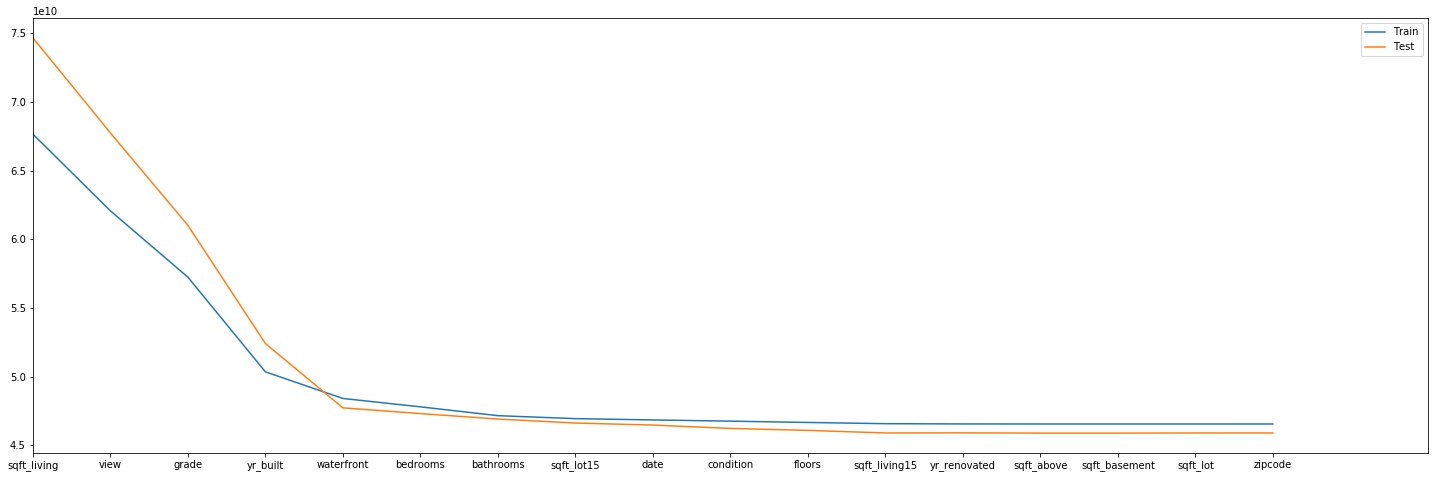

In [0]:
x = actuales

plt.figure(figsize=(25,8))
plt.xlim(0,18)
plt.plot(x, train_error)
plt.plot(x, test_error)
plt.legend(['Train', 'Test'])

Podemos apreciar que con menos atributos claramente el modelo obtiene un mejor desempeño en entrenamiento, pero al aumentar los atributos considerados comienza a tener un mejor desempeño en el conjunto de test. Incluso si analizamos scores deberíamos tener algo parecido.

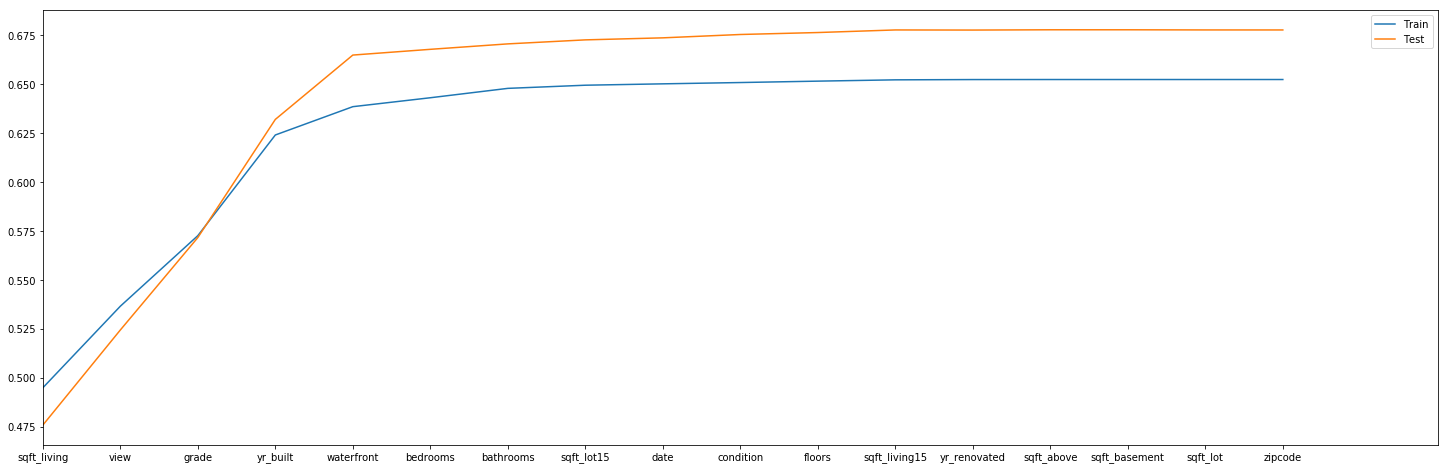

In [0]:
plt.figure(figsize=(25,8))
plt.xlim(0,18)
plt.plot(x, train_score)
plt.plot(x, test_score)
plt.legend(['Train', 'Test'])

Donde podemos apreciar que testing comienza a tener un desempeño sumamente alto comparado al de entrenamiento a medida que agregar atributos al modelo.

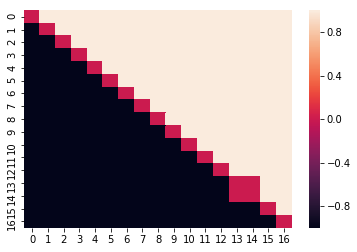

In [0]:
heat(train_error)

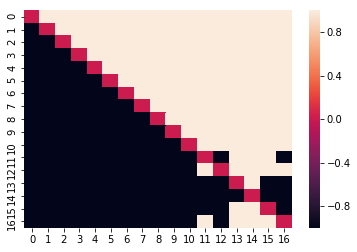

In [0]:
heat(test_error)

## 2.5) Mutual Information

La Mutual Information (MI) entre dos variables aleatorias es un valor no negativo que mide la dependencia entre las variables. Es igual a cero si y sólo si dos variables aleatorias son independientes, y un valor más alto impica una dependencia mayor.

Nuestra intención entonces es tomar nuestro target, que es el precio, y hacer este análisis de dependencia entre las variables para identificar mejor cuales atributos son mejores.

In [0]:
MI = list(zip(mutual_info_regression(data_x_train, data_y_train.reshape(len(data_y_train), )), data_x_train.columns))
print(MI)

[(0.0, 'date'), (0.08281085828312751, 'bedrooms'), (0.20428527404871888, 'bathrooms'), (0.35544473018829326, 'sqft_living'), (0.062002714108263746, 'sqft_lot'), (0.07098928711227392, 'floors'), (0.00785217825966833, 'waterfront'), (0.052545658802717554, 'view'), (0.009336143888879267, 'condition'), (0.34257500195888557, 'grade'), (0.2594232929391431, 'sqft_above'), (0.0750999259111711, 'sqft_basement'), (0.07739433644857652, 'yr_built'), (0.0070298486851749775, 'yr_renovated'), (0.4171459382920135, 'zipcode'), (0.26808638379504846, 'sqft_living15'), (0.08179621532231263, 'sqft_lot15')]


Haremos primero una comparación de mayor a menor para ver la dependencia de los atributos con el target, luego vemos si ese orden corresponde al que teníamos anteriormente al entrenar el modelo.

In [0]:
MI_sort = sorted(MI)

In [0]:
for element in MI_sort[::-1]:
  print(element)

(0.4171459382920135, 'zipcode')
(0.35544473018829326, 'sqft_living')
(0.34257500195888557, 'grade')
(0.26808638379504846, 'sqft_living15')
(0.2594232929391431, 'sqft_above')
(0.20428527404871888, 'bathrooms')
(0.08281085828312751, 'bedrooms')
(0.08179621532231263, 'sqft_lot15')
(0.07739433644857652, 'yr_built')
(0.0750999259111711, 'sqft_basement')
(0.07098928711227392, 'floors')
(0.062002714108263746, 'sqft_lot')
(0.052545658802717554, 'view')
(0.009336143888879267, 'condition')
(0.00785217825966833, 'waterfront')
(0.0070298486851749775, 'yr_renovated')
(0.0, 'date')


In [0]:
for element in actuales:
  print(element)

sqft_living
view
grade
yr_built
waterfront
bedrooms
bathrooms
sqft_lot15
date
condition
floors
sqft_living15
yr_renovated
sqft_above
sqft_basement
sqft_lot
zipcode


Encontramos interesante que zipcode sea el atributo que más correlación tiene con la vivienda, siendo que en nuestro experimento anterior fue el atributo que menos aportaba y que incluso, empeoraba el error. Lo anterior puede implicar que zipcode y price tienen una gran correlación pero no es necesariamente lineal, por lo tanto, la regresión no puede extraer completamente esta relación.

## 2.6) Más variables

Ya descubrimos que zipcode tiene una gran dependencia con la variable price, pero debemos darnos cuenta que zipcode sigue siendo una variable categórica. Por lo tanto la transformaremos utilizando one hot encoding y haremos nuevamente el análisis para comprobar si hay una mejora en los entrenamientos.

In [0]:
data_pre_dummies = pd.get_dummies(df.zipcode)

df.drop(columns = 'zipcode')
columns = df.columns
data_pre_dummies[columns] = df[columns]

In [0]:
data_pre_train, data_pre_test = train_test_split(data_pre_dummies, test_size= 0.10)

data_y_train = data_pre_train.pop('price')
data_y_test = data_pre_test.pop('price')

data_x_train = data_pre_train
data_x_test = data_pre_test

data_y_train = data_y_train.values.reshape(-1,1)
data_y_test = data_y_test.values.reshape(-1,1)

In [0]:
stand_x = StandardScaler()
stand_x = stand_x.fit(data_x_train)

data_x_train = pd.DataFrame(stand_x.transform(data_x_train), columns=data_x_train.columns)
data_x_val =  pd.DataFrame(stand_x.transform(data_x_train), columns=data_x_test.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [0]:
restantes = list(data_x_train.columns)
actuales = []
error_actual = ((data_y_train - data_y_train.mean())**2).mean()
all_errors = [error_actual]
print('0: None')
while restantes:
  errores = list()
  for atributo_candidato in restantes:
    model = LinearRegression()
    folds = KFold(5)
    featurerr = 0
    for train_index, test_index in folds.split(data_x_train.values):
      model.fit(data_x_train[actuales + [atributo_candidato]].values[train_index], data_y_train[train_index])
      predict = model.predict(data_x_train[actuales + [atributo_candidato]].values[train_index])
      featurerr += mean_squared_error(data_y_train[train_index], predict)
    errores.append(featurerr / 5)
  val, idx = min((val, idx) for (idx, val) in enumerate(errores))
  actuales.append(restantes[idx])
  del restantes[idx]
  all_errors.append(val)
  print(len(actuales), ": ", actuales)

0: None
1 :  ['sqft_living']
2 :  ['sqft_living', 'view']
3 :  ['sqft_living', 'view', 98004]
4 :  ['sqft_living', 'view', 98004, 'grade']
5 :  ['sqft_living', 'view', 98004, 'grade', 'yr_built']
6 :  ['sqft_living', 'view', 98004, 'grade', 'yr_built', 98039]
7 :  ['sqft_living', 'view', 98004, 'grade', 'yr_built', 98039, 'waterfront']
8 :  ['sqft_living', 'view', 98004, 'grade', 'yr_built', 98039, 'waterfront', 98112]
9 :  ['sqft_living', 'view', 98004, 'grade', 'yr_built', 98039, 'waterfront', 98112, 98040]
10 :  ['sqft_living', 'view', 98004, 'grade', 'yr_built', 98039, 'waterfront', 98112, 98040, 98033]
11 :  ['sqft_living', 'view', 98004, 'grade', 'yr_built', 98039, 'waterfront', 98112, 98040, 98033, 98023]
12 :  ['sqft_living', 'view', 98004, 'grade', 'yr_built', 98039, 'waterfront', 98112, 98040, 98033, 98023, 'bedrooms']
13 :  ['sqft_living', 'view', 98004, 'grade', 'yr_built', 98039, 'waterfront', 98112, 98040, 98033, 98023, 'bedrooms', 98105]
14 :  ['sqft_living', 'view', 980

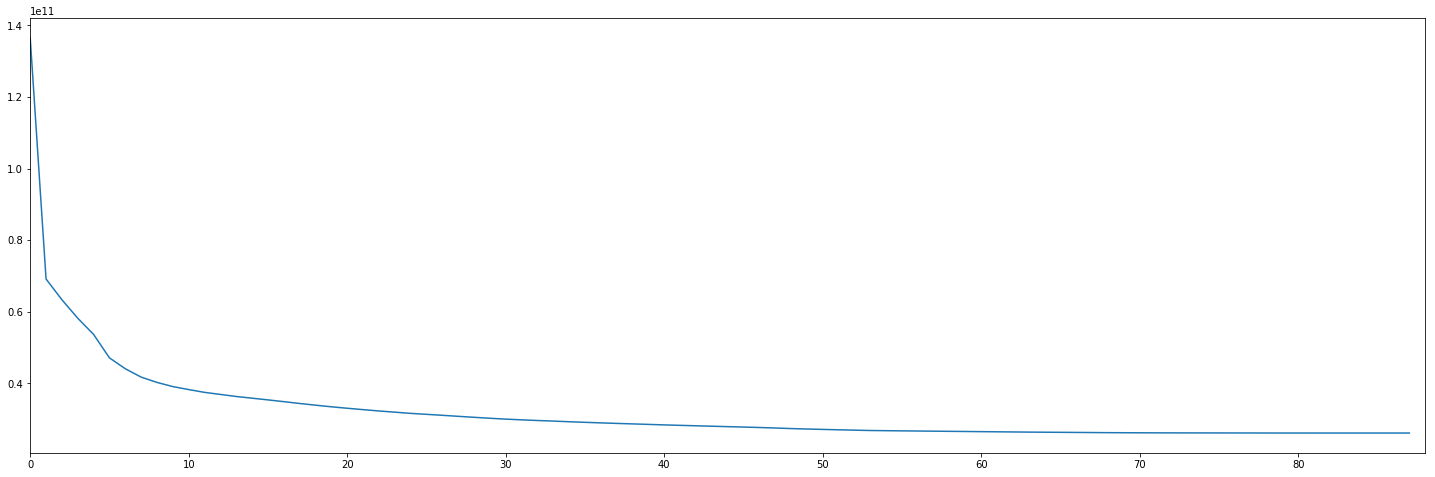

In [0]:
x = list(range(0,len(all_errors)))

plt.figure(figsize=(25,8))
plt.xlim(0,len(all_errors))
plt.plot(x, all_errors)

Finalmente podemos apreciar que el error disminuye mucho comparado a considerar zipcode como solo numérico. Eso si, el tiempo de entrenamiento fue mayor, pero principalmente por temas de considerar todas las columnas nuevas que aparecieron al categorizar zipcode. 

La razón principal de esta reducción es que cuando zipcode era numérico, la regresión lineal no podía encontrar información coherente del zipcode ya que implica geografía, la cual no puede ser expresada en forma lineal. En cambio, si utilizamos que cada zipcode sea una categoría, puede hacer una comparación lineal entre cada zipcode en una sola muestra. Así se podra obtener más información de zipcode en la cual, anteriormente vimos que poseía una gran correlación con el target price. 